<a href="https://colab.research.google.com/github/Seyed-Ali-Ahmadi/Building-Damage-Assessment/blob/master/01_manipulate_JSON_label_files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 1: Manipulation

In this section I will try to create building masks for a single image.

In [ ]:
import json
import re
from skimage.draw import polygon
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
path = '/content/drive/My Drive/subset_1/guatemala-volcano_00000000_post_disaster.json'
# METHOD 1
with open(path) as f:
  data = json.load(f)

# METHOD 2
# Alternative solution to read the JSON file:
# Opening JSON file 
f = open(path,) 
# returns JSON object as  
# a dictionary 
data = json.load(f) 

In [ ]:
print(type(data))
print('---------------------')
print(data.keys())
print('---------------------')
for key in data.keys():
  print('The key whose keys are being displayed is "' + key + '"')
  print(data[key].keys())
  print('............')

<class 'dict'>
---------------------
dict_keys(['features', 'metadata'])
---------------------
The key whose keys are being displayed is "features"
dict_keys(['lng_lat', 'xy'])
............
The key whose keys are being displayed is "metadata"
dict_keys(['sensor', 'provider_asset_type', 'gsd', 'capture_date', 'off_nadir_angle', 'pan_resolution', 'sun_azimuth', 'sun_elevation', 'target_azimuth', 'disaster', 'disaster_type', 'catalog_id', 'original_width', 'original_height', 'width', 'height', 'id', 'img_name'])
............


In [ ]:
print('There are << ' + str(len(data['features']['xy'])) + ' >> buildings in this image.')

There are << 10 >> buildings in this image.


In [ ]:
building_mask = np.zeros((1024, 1024))

for building in data['features']['xy']:
  
  vertices = building['wkt']
  vertices = vertices.partition('POLYGON ((')[2].partition('))')[0].split(', ')
  n_vertices = len(vertices)

  print('This is a < ' + 
        building['properties']['feature_type'] + 
        ' > of type << ' + 
        building['properties']['subtype'] + ' >> with ' + 
        str(n_vertices) + ' vertices. ')

  rows = []
  cols = []
  for vertex in vertices:
    cols.append(float(vertex.split(' ')[0]))
    rows.append(float(vertex.split(' ')[1]))

  rr, cc = polygon(rows, cols, (1024, 1024))
  
  building_mask[rr, cc] = 1

This is a < building > of type << no-damage >> with 9 vertices. 
This is a < building > of type << no-damage >> with 15 vertices. 
This is a < building > of type << no-damage >> with 9 vertices. 
This is a < building > of type << no-damage >> with 6 vertices. 
This is a < building > of type << no-damage >> with 10 vertices. 
This is a < building > of type << no-damage >> with 7 vertices. 
This is a < building > of type << no-damage >> with 6 vertices. 
This is a < building > of type << no-damage >> with 5 vertices. 
This is a < building > of type << no-damage >> with 4 vertices. 
This is a < building > of type << no-damage >> with 5 vertices. 


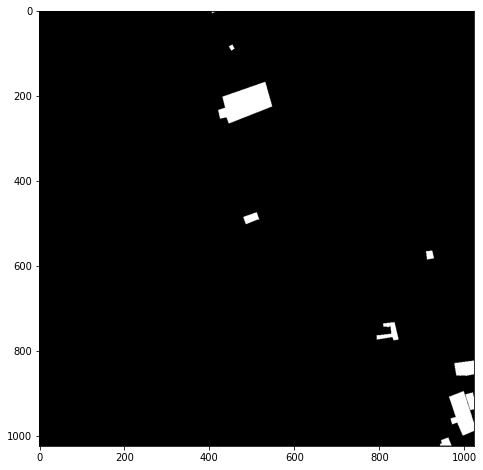

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(building_mask, cmap='gray')
plt.show()

# Section 2: Automation

In this section I will try to make the above code more efficient such that it gets a directory as input and creates the mask images as outputs based on their GeoJSON label files.


In [ ]:
import os
import re
import json
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import polygon
from skimage.io import imread


rootDir = '/content/drive/My Drive/subset_labels/'
jsonFiles = os.listdir(rootDir)

imageDir = '/content/drive/My Drive/subset_images/'

for jsonFile in jsonFiles:
  f = open(rootDir + jsonFile,)
  data = json.load(f)

  # Create a new building mask.
  building_mask = np.zeros((1024, 1024))
  bounding_box = np.zeros((1024, 1024))

  # Read the corresponding image of the same JSON file.
  image = imread(imageDir + jsonFile[:-4] + 'png')

  # Loop through buildings in each image.
  for building in data['features']['xy']:
    
    # Extract x-y coordinate of each vertex from decoding the json pattern.
    vertices = building['wkt'].partition('POLYGON ((')[2].partition('))')[0].split(', ')
    n_vertices = len(vertices)

    rows = []
    cols = []
    for vertex in vertices:
      cols.append(float(vertex.split(' ')[0]))
      rows.append(float(vertex.split(' ')[1]))

    # Fill the location of each building.
    rr, cc = polygon(rows, cols, (1024, 1024))
    building_mask[rr, cc] = 1
    # Fill the location of its bounding box for further use.
    br, bc = polygon([min(rows), min(rows), max(rows), max(rows), min(rows)],
                     [min(cols), max(cols), max(cols), min(cols), min(cols)],
                     (1024, 1024))    
    bounding_box[br, bc] = 1

    mask_box = building_mask + bounding_box
    building_crop = image[int(np.floor(min(rows))) - 10:
                          int(np.ceil(max(rows))) + 10,
                          int(np.floor(min(cols))) - 10:
                          int(np.ceil(max(cols))) + 10, :]
    mask_crop = mask_box[int(np.floor(min(rows))) - 10:
                         int(np.ceil(max(rows))) + 10,
                         int(np.floor(min(cols))) - 10:
                         int(np.ceil(max(cols))) + 10]

    plt.figure(figsize=(15, 12))
    plt.subplot(121), plt.imshow(mask_crop)
    plt.subplot(122), plt.imshow(building_crop)
    plt.show()

  
  # plt.figure(figsize=(15, 12))
  # plt.subplot(131), plt.imshow(mask_box, cmap='jet')
  # plt.subplot(132), plt.imshow(mask_crop)
  # plt.subplot(133), plt.imshow(building_crop)
  # plt.show()